In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [78]:
import logging
from pathlib import Path

from hydra import initialize, compose
import numpy as np
from omegaconf import OmegaConf
from scipy.io import loadmat
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange

from src.encoding.ecog import timit as timit_encoding
from src.encoding.ecog import get_electrode_df

In [99]:
base_dir = "../.."

audio_sfreq = 16000

English = {
	'consonants': ['B', 'CH', 'D', 'DH', 'F', 'G', 'HH', 'JH', 'K', 'L', 'M', 'N', 
	               'NG', 'P', 'R', 'S', 'SH', 'T', 'TH', 'V', 'W', 'Y', 'Z', 'ZH'],
	'vowels': [ 'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'ER', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW'],
	'onsets': ['P', 'T', 'K', 'B', 'D', 'G', 'F', 'V', 'TH', 'DH', 'S', 'Z', 'SH', 'CH', 'JH', 'M',
                'N', 'R', 'L', 'HH', 'W', 'Y', 'P R', 'T R', 'K R', 'B R', 'D R', 'G R', 'F R',
                'TH R', 'SH R', 'P L', 'K L', 'B L', 'G L', 'F L', 'S L', 'T W', 'K W', 'D W', 
                'S W', 'S P', 'S T', 'S K', 'S F', 'S M', 'S N', 'G W', 'SH W', 'S P R', 'S P L',
                'S T R', 'S K R', 'S K W', 'S K L', 'TH W', 'ZH', 'P Y', 'K Y', 'B Y', 'F Y', 
                'HH Y', 'V Y', 'TH Y', 'M Y', 'S P Y', 'S K Y', 'G Y', 'HH W', '']
}

In [79]:
L = logging.getLogger(__name__)

In [5]:
with initialize(version_base=None, config_path=f"{base_dir}/conf_encoder/"):
    encoder_config = compose(config_name="config",
                  overrides=[
                    "+data=[{subject: 'EC196', block: 'B1'}]",
                    f"+dataset_path={base_dir}/outputs/preprocessed_data/timit",
                    "feature_sets=syllable",
                    f"+feature_sets.model_features.syllable.embeddings_path={base_dir}/outputs/model_embeddings/timit/w2v2_6/rnn_8-weightdecay0.01/syllable_10frames/embeddings.npy",
                    f"+feature_sets.model_features.syllable.equivalence_path={base_dir}/outputs/equivalence_datasets/timit/w2v2_6/syllable_10frames/equivalence.pkl",
                    f"+feature_sets.model_features.syllable.hidden_state_path={base_dir}/outputs/hidden_states/timit/w2v2_6/hidden_states.pkl",
                    f"+feature_sets.model_features.syllable.state_space_path={base_dir}/outputs/state_space_specs/timit/w2v2_6/state_space_specs.pkl",
                  ])
    print(OmegaConf.to_yaml(encoder_config))

cv:
  _target_: sklearn.model_selection.KFold
  n_splits: 3
  shuffle: false
feature_sets:
  baseline_features:
  - onset
  - phnfeatConsOnset
  - maxDtL
  - formantMedOnset
  - F0
  - aud
  model_features:
    syllable:
      base_model: w2v2_6
      model: rnn_8-weightdecay0.01
      equivalence: syllable_10frames
      state_space: syllable
      featurization: mean
      embeddings_path: ../../outputs/model_embeddings/timit/w2v2_6/rnn_8-weightdecay0.01/syllable_10frames/embeddings.npy
      equivalence_path: ../../outputs/equivalence_datasets/timit/w2v2_6/syllable_10frames/equivalence.pkl
      hidden_state_path: ../../outputs/hidden_states/timit/w2v2_6/hidden_states.pkl
      state_space_path: ../../outputs/state_space_specs/timit/w2v2_6/state_space_specs.pkl
corpus:
  name: timit
  sentdetV: v4
  paths:
    corpus_path: /data_store1/human/prcsd_data
    data_path: /userdata/ilinabg/data
    info_path: /userdata/jgauthier/ilina_timit/speech_analysis
    out_file_glob: HilbAA_70to1

## Prepare model and dataset representations

In [46]:
feature_spec = next(iter(encoder_config.feature_sets.model_features.values()))
model = timit_encoding.ContrastiveModelSnapshot.from_config(encoder_config, feature_spec)
model.dataset = model.dataset.with_format("numpy")

In [70]:
data_spec = next(iter(encoder_config.data))
out = timit_encoding.prepare_out_file(encoder_config, data_spec)

## Alignment pre-computation

In [23]:
out_all_names = [out_i["name"] for out_i in out]
name_to_trial_idx = {name: idx for idx, name in enumerate(out_all_names)}
name_to_item_idx, name_to_frame_bounds, compression_ratios = {}, {}, {}
def process_item(item):
    name = Path(item["file"]).parent.stem.lower() + "_" + item["id"].lower()
    if name in out_all_names:
        name_to_item_idx[name] = item["idx"]

        frame_start, frame_end = model.hidden_states.frames_by_item[item["idx"]]
        name_to_frame_bounds[name] = (frame_start, frame_end)
        compression_ratios[name] = (frame_end - frame_start) / len(item["input_values"])
model.dataset.map(process_item)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'original_idx', 'original_split', 'idx', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 6300
})

In [28]:
item_idx_to_name = {v: k for k, v in name_to_item_idx.items()}

In [13]:
# Make sure that ECoG data and model embeddings are of approximately the same length,
# modulo sampling differences. Compute length of each sentence in seconds according
# to two sources:
comparisons = [(out_i["resp"].shape[1] / out_i["dataf"] - out_i["befaft"].sum(), # remove padding
                (name_to_frame_bounds[out_i['name']][1] - name_to_frame_bounds[out_i['name']][0]) / compression_ratios[out_i["name"]] / audio_sfreq)
                for out_i in out if out_i["name"] in name_to_frame_bounds]
np.testing.assert_allclose(*zip(*comparisons), atol=0.05,
                           err_msg="ECoG data and model embeddings should be of approximately the same length")

## Assertions

### Sound onset alignment

In [22]:
# TODO what is the second item of soundOns?

In [86]:
mismatched_onsets, mismatched_offsets = [], []
def check_sound_bounds(item):
    if item["idx"] not in item_idx_to_name:
        return
    name = item_idx_to_name[item["idx"]]
    trial = out[name_to_trial_idx[name]]

    # np approx close
    if not np.allclose(item["word_detail"]["start"][0] / audio_sfreq, trial["soundOns"][0], atol=0.05):
        mismatched_onsets.append((name, item["word_detail"]["start"] / audio_sfreq, trial["soundOns"][0]))
    if not np.allclose(item["word_detail"]["stop"][-1] / audio_sfreq, trial["soundOns"][1], atol=0.05):
        mismatched_offsets.append((name, item["word_detail"]["stop"][-1] / audio_sfreq, trial["soundOns"][1]))

    # Assert that audio annotations are nonzero only within the onset/offset region
    check_audio_annotations = ["F0", "maxDtL", "formantMedOnset"]
    for annotation in check_audio_annotations:
        annot_is_set = np.nonzero(trial[annotation] != 0)[1]

        try:
            np.testing.assert_array_less(trial["soundOns"][0], annot_is_set[0] / trial["dataf"])
            np.testing.assert_array_less(annot_is_set[-1] / trial["dataf"], trial["soundOns"][1])
        except AssertionError:
            L.warning(f"Annotation {annotation} for {name} is nonzero outside of the onset/offset region")

model.dataset.map(check_sound_bounds)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Annotation F0 for fdaw0_si1406 is nonzero outside of the onset/offset region
Annotation maxDtL for fdaw0_si1406 is nonzero outside of the onset/offset region
Annotation formantMedOnset for fdaw0_si1406 is nonzero outside of the onset/offset region
Annotation F0 for fdml0_si1779 is nonzero outside of the onset/offset region
Annotation maxDtL for fdml0_si1779 is nonzero outside of the onset/offset region
Annotation formantMedOnset for fdml0_si1779 is nonzero outside of the onset/offset region
Annotation F0 for fdml0_si2075 is nonzero outside of the onset/offset region
Annotation maxDtL for fdml0_si2075 is nonzero outside of the onset/offset region
Annotation formantMedOnset for fdml0_si2075 is nonzero outside of the onset/offset region
Annotation F0 for fetb0_si1148 is nonzero outside of the onset/offset region
Annotation maxDtL for fetb0_si1148 is nonzero outside of the onset/offset region
Annotation formantMedOnset for fetb0_si1148 is nonzero outside of the onset/offset region
Annotati

Dataset({
    features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'original_idx', 'original_split', 'idx', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 6300
})

In [81]:
mismatched_onsets

[]

In [82]:
mismatched_offsets

[('fljg0_si2241', 1.8770625, 1.950375),
 ('fklc1_si2308', 1.5821875, 1.693625),
 ('fgjd0_si1179', 1.7225, 1.879875)]

### Word onset alignment

In [61]:
mismatched_word_counts = []
mismatched_onsets = []
def check_word_alignment(item):
    if item["idx"] not in item_idx_to_name:
        return
    name = item_idx_to_name[item["idx"]]
    trial = out[name_to_trial_idx[name]]

    word_starts = np.flatnonzero(trial["wordOns"] == 1) / trial["dataf"] - trial["befaft"][0]

    if len(word_starts) != len(item["word_detail"]["start"]):
        mismatched_word_counts.append((name, len(word_starts), len(item["word_detail"]["start"])))
    elif not np.allclose(word_starts, item["word_detail"]["start"] / audio_sfreq, atol=0.02):
        mismatched_onsets.append((name, word_starts, item["word_detail"]["start"] / audio_sfreq))
model.dataset.map(check_word_alignment)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'original_idx', 'original_split', 'idx', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 6300
})

In [63]:
mismatched_word_counts

[]

In [62]:
mismatched_onsets

[]

### Phoneme feature onset alignment

In [71]:
check_idx = 0
trial = out[check_idx]
name = trial["name"]
item_idx = name_to_item_idx[name]
item = model.dataset[item_idx]

In [103]:
mismatched_consonant_counts = []
mismatched_consonant_onsets = []

def check_consonant_alignment(item):
    if item["idx"] not in item_idx_to_name:
        return
    name = item_idx_to_name[item["idx"]]
    trial = out[name_to_trial_idx[name]]

    consonant_onsets = sorted(np.unique(np.nonzero(trial["phnfeatConsOnset"])[1]) / trial["dataf"] - trial["befaft"][0])
    item_consonant_onsets = np.array([item["phonemic_detail"]["start"][idx] / audio_sfreq
                                      for idx in range(len(item["phonemic_detail"]["start"]))
                                      if item["phonemic_detail"]["utterance"][idx] not in English["vowels"]])
    
    if len(consonant_onsets) != len(item_consonant_onsets):
        mismatched_consonant_counts.append((name, len(consonant_onsets), len(item_consonant_onsets)))
    elif not np.allclose(consonant_onsets, item_consonant_onsets, atol=0.02):
        mismatched_consonant_onsets.append((name, consonant_onsets, item_consonant_onsets))
model.dataset.map(check_consonant_alignment)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'original_idx', 'original_split', 'idx', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 6300
})

In [107]:
print(f"Consonant count mismatches: {len(mismatched_consonant_counts)} ({len(mismatched_consonant_counts) / len(out) * 100:.2f}%)")
print(f"Average mismatch: {np.mean(np.abs([mismatch[1] - mismatch[2] for mismatch in mismatched_consonant_counts])):.2f} consonants")

Consonant count mismatches: 414 (82.97%)
Average mismatch: 2.26 consonants


Text(0.5, 9.444444444444438, 'out annotation consonant count - model annotation consonant count')

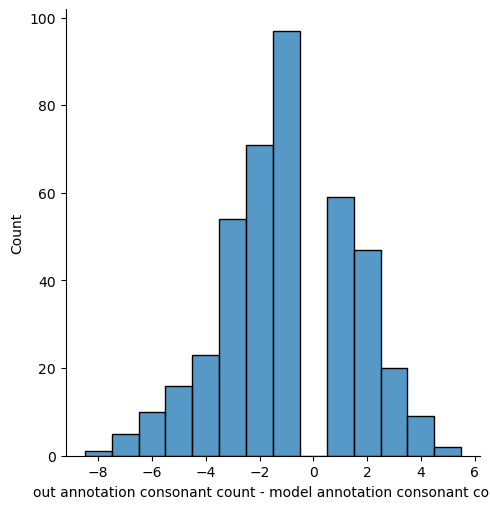

In [110]:
g = sns.displot([mismatch[1] - mismatch[2] for mismatch in mismatched_consonant_counts],
                discrete=True)
g.axes.ravel()[0].set_xlabel("out annotation consonant count - model annotation consonant count")

In [100]:
np.array([item["phonemic_detail"]["start"][idx] / audio_sfreq
          for idx in range(len(item["phonemic_detail"]["start"]))
          if item["phonemic_detail"]["utterance"][idx] not in English["vowels"]])

array([0.1375   , 0.1625   , 0.2925   , 0.37     , 0.6370625, 0.7575   ,
       0.9158125, 0.966    , 1.1975   , 1.2825   , 1.5125   ])

In [101]:
np.array([item["phonemic_detail"]["utterance"][idx]
          for idx in range(len(item["phonemic_detail"]["start"]))
          if item["phonemic_detail"]["utterance"][idx] not in English["vowels"]])

array(['B', 'R', 'K', 'S', 'R', 'N', 'L', 'T', 'N', 'T', 'V'], dtype='<U1')

In [84]:
trial["formantMedOnset"].shape

(4, 280)

In [15]:
sorted(out[0].keys())

['F0',
 'F13P',
 'F1Trans',
 'F23P',
 'F2Trans',
 'Trials',
 'aud',
 'befaft',
 'biphn',
 'biphnNorm',
 'biphnNormbwmat',
 'biphnNormfwmat',
 'biphnbwmat',
 'biphnfwmat',
 'biphnlist',
 'dataf',
 'duration',
 'f0',
 'formantMedOnset',
 'formants',
 'frmMedOns',
 'frmMedVal',
 'loudness',
 'loudnessCycleDur',
 'loudnessCycleId',
 'loudnessExtLoc',
 'loudnessExtVal',
 'loudnessRelExtLoc',
 'loudnessSentIdlong',
 'loudnessSentOns',
 'loudnessall',
 'loudnessallNames',
 'loudnesscyclePeakPhn',
 'maxDtL',
 'name',
 'offset',
 'onsOff',
 'onset',
 'pause',
 'phnRed',
 'phnRedOnset',
 'phnfeat',
 'phnfeatConsOnset',
 'phnfeatonset',
 'phnmat',
 'phnmatonset',
 'phnnames',
 'phnnamesRed',
 'resp',
 'sentId',
 'sentence_onset',
 'sound',
 'soundOns',
 'soundf',
 'stress',
 'sylOns',
 'syllableNumber',
 'syltype',
 'vowel',
 'vowelId',
 'vowelStress',
 'vowelTimes',
 'wordL',
 'wordList',
 'wordOns']